In [45]:
import numpy as np
import pandas as pd
import os
import json

import onnx
import onnxruntime as rt

import torch
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms

from PIL import Image

In [8]:
# 学習済みResNet50モデルのロード
model = resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:11<00:00, 8.67MB/s]


In [11]:
# 推論モードに設定
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# ダミー入力データの作成 (バッチサイズ1, 3チャンネル, 224x224ピクセル)
dummy_input = torch.randn(1, 3, 224, 224)

In [14]:
# エクスポート先のディレクトリを作成
export_dir = "models"
os.makedirs(export_dir, exist_ok=True)

# ONNXモデルのパス
onnx_model_path = os.path.join(export_dir, "resnet50.onnx")

In [21]:
onnx_model_path

'models/resnet50.onnx'

In [22]:
# モデルをONNX形式でエクスポート
torch.onnx.export(
    model,                      # モデル本体
    dummy_input,                # モデルへの入力
    onnx_model_path,            # 出力ファイル名
    export_params=True,         # モデルのパラメータも保存
    opset_version=11,           # 使用するONNXのopsetバージョン
    do_constant_folding=True,   # 定数フォールディングの最適化を実施
    input_names=['input'],      # モデルの入力名
    output_names=['output'],    # モデルの出力名
    dynamic_axes={
        'input': {0: 'batch_size'},   # バッチサイズの次元を動的に
        'output': {0: 'batch_size'}
    }
)


In [23]:
# ONNXモデルのロード
onnx_model = onnx.load(onnx_model_path)

# モデルのチェック
try:
    onnx.checker.check_model(onnx_model)
    print("ONNXモデルのチェックに成功しました。")
except onnx.checker.ValidationError as e:
    print("ONNXモデルのチェックに失敗しました:", e)

ONNXモデルのチェックに成功しました。


In [25]:
# InferenceSessionの作成
session = rt.InferenceSession(onnx_model_path)

# モデルの入力名の取得
input_name = session.get_inputs()[0].name
print(f"モデルの入力名: {input_name}")

# モデルの出力名の取得
output_name = session.get_outputs()[0].name
print(f"モデルの出力名: {output_name}")

モデルの入力名: input
モデルの出力名: output


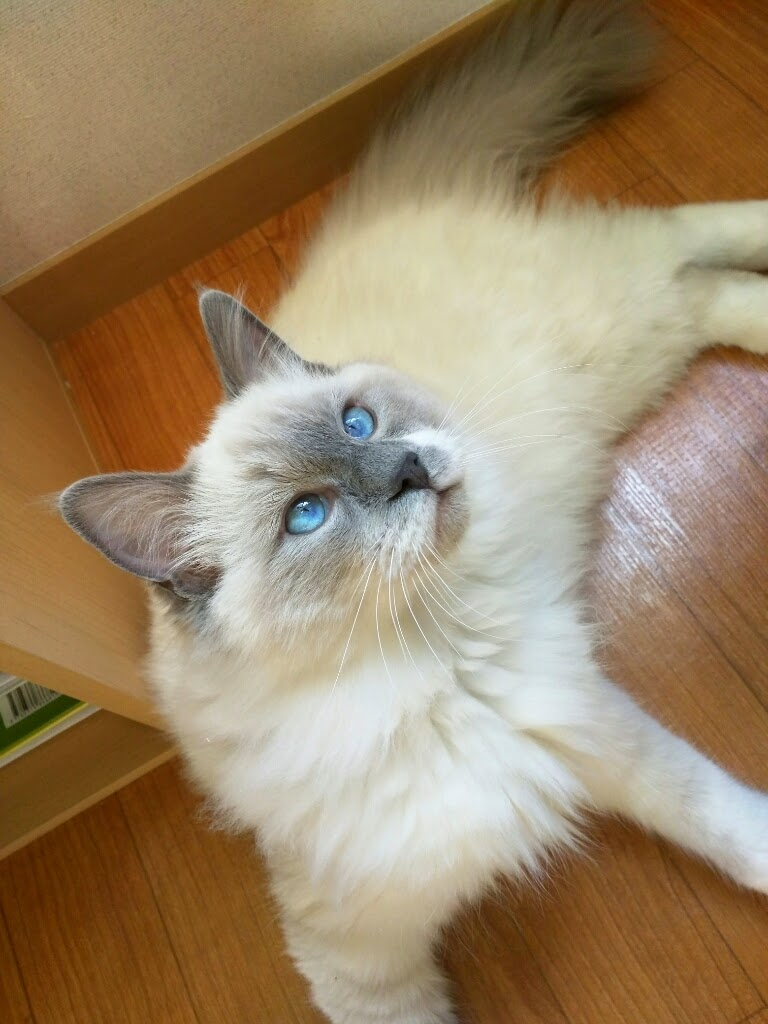

In [32]:
# 画像のパス
image_path = "cat.jpg"

# 画像の読み込み
image = Image.open(image_path).convert('RGB')

image

In [34]:
# 前処理の定義
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNetの平均
        std=[0.229, 0.224, 0.225]    # ImageNetの標準偏差
    )
])

In [38]:
# 画像の前処理
input_tensor = preprocess(image)

print(input_tensor.shape)

input_tensor

torch.Size([3, 224, 224])


tensor([[[ 0.5878,  0.5364,  0.5707,  ...,  0.1083,  0.0569,  0.0569],
         [ 0.5878,  0.5878,  0.6221,  ...,  0.1083,  0.0569,  0.0398],
         [ 0.5878,  0.6049,  0.5707,  ...,  0.0912,  0.0569,  0.0227],
         ...,
         [-0.6794, -0.6452, -0.6452,  ...,  1.1872,  1.1358,  1.0673],
         [-0.6965, -0.6965, -0.6452,  ...,  1.1529,  1.1187,  1.0844],
         [-0.7137, -0.6794, -0.6452,  ...,  1.0673,  1.0673,  1.1015]],

        [[ 0.2752,  0.2402,  0.2752,  ..., -0.6702, -0.7402, -0.7402],
         [ 0.2927,  0.3102,  0.3277,  ..., -0.6702, -0.7402, -0.7402],
         [ 0.2927,  0.3102,  0.2577,  ..., -0.6877, -0.7402, -0.7402],
         ...,
         [-1.3529, -1.3179, -1.3179,  ...,  1.3782,  1.3431,  1.2906],
         [-1.3880, -1.3704, -1.3179,  ...,  1.3081,  1.2906,  1.2906],
         [-1.3880, -1.3529, -1.3179,  ...,  1.2031,  1.2381,  1.2731]],

        [[-0.1138, -0.1661, -0.1138,  ..., -1.4036, -1.4559, -1.4733],
         [-0.1138, -0.0964, -0.0615,  ..., -1

In [41]:
# バッチ次元の追加
input_batch = input_tensor.unsqueeze(0).numpy()

print(input_batch.shape)
input_batch

(1, 3, 224, 224)


array([[[[ 0.5878072 ,  0.5364329 ,  0.57068247, ...,  0.10831413,
           0.05693974,  0.05693974],
         [ 0.5878072 ,  0.5878072 ,  0.6220567 , ...,  0.10831413,
           0.05693974,  0.03981499],
         [ 0.5878072 ,  0.60493195,  0.57068247, ...,  0.09118938,
           0.05693974,  0.02269024],
         ...,
         [-0.67942464, -0.6451751 , -0.6451751 , ...,  1.1871736 ,
           1.1357993 ,  1.0673003 ],
         [-0.69654936, -0.69654936, -0.6451751 , ...,  1.1529241 ,
           1.1186745 ,  1.0844251 ],
         [-0.7136741 , -0.67942464, -0.6451751 , ...,  1.0673003 ,
           1.0673003 ,  1.1015497 ]],

        [[ 0.2752102 ,  0.2401962 ,  0.2752102 , ..., -0.670168  ,
          -0.740196  , -0.740196  ],
         [ 0.29271722,  0.3102242 ,  0.3277312 , ..., -0.670168  ,
          -0.740196  , -0.740196  ],
         [ 0.29271722,  0.3102242 ,  0.2577032 , ..., -0.687675  ,
          -0.740196  , -0.740196  ],
         ...,
         [-1.352941  , -1.317927  

In [44]:
# 推論の実行
outputs = session.run([output_name], {input_name: input_batch})

# 出力の取得
output = outputs[0]

print(output.shape)
output

(1, 1000)


array([[-3.27789259e+00, -2.49929380e+00, -6.39709055e-01,
        -1.49266362e-01, -5.96655488e-01,  2.69032344e-02,
        -9.47036505e-01, -1.69809175e+00, -2.13861197e-01,
        -1.82346129e+00, -2.99115801e+00, -3.39424753e+00,
        -1.81914818e+00, -1.67251098e+00, -3.16670752e+00,
        -1.36155748e+00,  2.05542183e+00,  4.95575237e+00,
        -3.97781551e-01, -8.54468167e-01,  7.12623537e-01,
        -2.65687078e-01, -1.94672036e+00,  1.30018783e+00,
        -5.81504941e-01, -3.12500501e+00, -3.97297072e+00,
        -3.94586277e+00, -1.93771219e+00, -1.94111443e+00,
        -2.98131371e+00, -3.88134432e+00, -3.95876551e+00,
        -2.07385206e+00, -1.39713597e+00, -2.73056936e+00,
        -1.68480241e+00, -1.84524322e+00, -8.62679183e-02,
        -1.85651886e+00, -1.59435368e+00, -1.28803682e+00,
        -1.45970964e+00, -9.46487963e-01, -1.87444687e-02,
        -1.49207628e+00, -1.72885132e+00, -1.41321886e+00,
        -3.51168942e+00, -2.97340965e+00, -2.86390185e+0

In [50]:
label_path = "image_net_labels.json"

with open(label_path, 'r') as f:
    class_idx = json.load(f)
    

In [53]:
# 出力をソフトマックスで正規化
probabilities = torch.nn.functional.softmax(torch.from_numpy(output[0]), dim=0)

print(probabilities.shape)
probabilities

torch.Size([1000])


tensor([3.0484e-08, 6.6407e-08, 4.2640e-07, 6.9633e-07, 4.4516e-07, 8.3047e-07,
        3.1358e-07, 1.4797e-07, 6.5277e-07, 1.3053e-07, 4.0607e-08, 2.7136e-08,
        1.3110e-07, 1.5180e-07, 3.4069e-08, 2.0717e-07, 6.3139e-06, 1.1479e-04,
        5.4311e-07, 3.4399e-07, 1.6487e-06, 6.1981e-07, 1.1540e-07, 2.9669e-06,
        4.5196e-07, 3.5520e-08, 1.5213e-08, 1.5631e-08, 1.1644e-07, 1.1605e-07,
        4.1008e-08, 1.6672e-08, 1.5430e-08, 1.0162e-07, 1.9993e-07, 5.2695e-08,
        1.4995e-07, 1.2772e-07, 7.4161e-07, 1.2629e-07, 1.6414e-07, 2.2297e-07,
        1.8780e-07, 3.1375e-07, 7.9342e-07, 1.8182e-07, 1.4349e-07, 1.9674e-07,
        2.4129e-08, 4.1334e-08, 4.6117e-08, 2.6589e-06, 1.1289e-07, 8.9573e-08,
        6.5913e-07, 2.8232e-08, 4.5729e-07, 1.0919e-08, 1.9298e-07, 2.8851e-07,
        4.8652e-07, 2.6374e-07, 4.6412e-07, 3.3807e-08, 1.4552e-07, 4.0284e-08,
        1.9267e-06, 5.4392e-07, 3.1797e-07, 1.0270e-07, 2.7291e-08, 2.1072e-07,
        1.2201e-07, 6.6662e-08, 1.3449e-

In [54]:
# 上位5件を取得
top5_prob, top5_catid = torch.topk(probabilities, 5)

In [56]:
print(top5_prob)
print(top5_catid)

tensor([0.6658, 0.2422, 0.0367, 0.0166, 0.0150])
tensor([284, 287, 283, 285, 281])
